# TORCH.AUTOGRAD를 사용한 자동 미분
신경망을 학습할 때 가장 자주 사용되는 알고리즘은 역전파이다.   
이 알고리즘에서, 매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 변화도(gradient)에 따라 조정된다.

이러한 변화도를 계산하기 위해 PyTorch에는 torch.autograd라고 불리는 자동 미분 엔진이 내장되어 있다. 이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원한다.

입력 x, 매개변수 w와 b, 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층 신경망을 가정.

In [37]:
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # Expected output
w = torch.randn(5,3, requires_grad= True)
b = torch.randn(3, requires_grad= True)
z = torch.matmul(x,w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)

## Tensor, Function과 연산그래프(Computational graph)
연산그래프 :
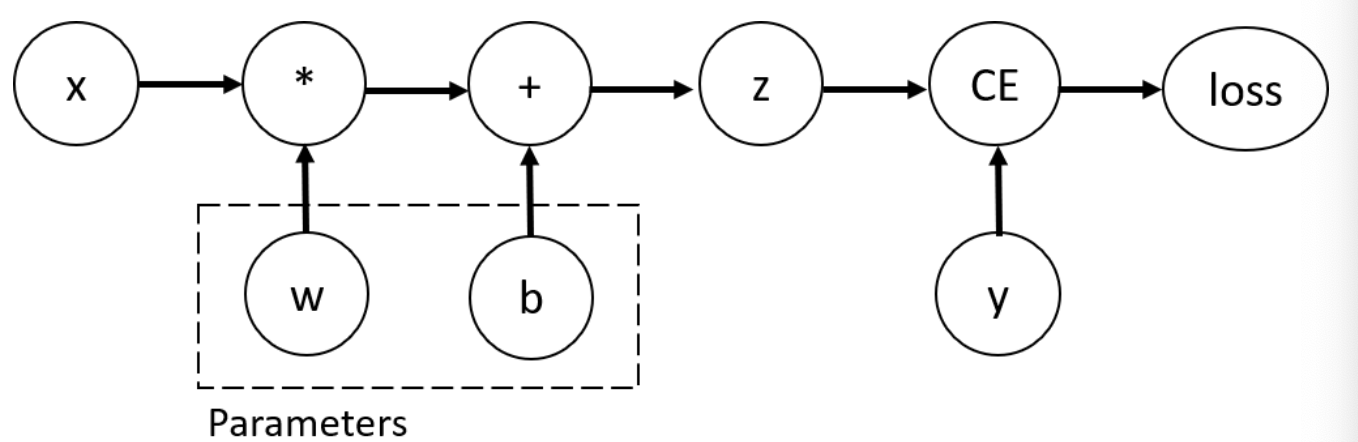

이 신경망에서, w와 b는 최적화를 해야 하는 매개변수이다. 따라서 이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 한다. 이를 위해 해당 텐서에 requires_grad 속성을 설정한다.

**참고**  
requires_grad의 값은 텐서를 생성할 때 설정하거나, 나중에 x.requires_grad_(True) 메소드를 사용하여 나중에 설정할 수 있다.

연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 Function 클래스의 객체이다. 
이 객체는 순전파 방향으로 함수를 계산하는 방법과 역방향 전파 단계에서 도함수를 계산하는 방법을 알고 있다. 역방향 전파 함수에 대한 참조는 텐서의 grad_fn 속성에 저장된다. 

In [38]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for z = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7fb1e0e67d00>
Gradient function for z = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7fb1f4580af0>


## 변화도(Gradient) 계산하기

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수를 계산해야한다. 
즉, x와 y의 일부 고정값에서 loss를 미분한 것이 필요하다.
이러한 도함수를 계산하기 위해, loss.backward()를 호출한 다음 w.grad와 b.grad에서 값을 가져온다.

In [39]:
print(w.grad)
print(b.grad)

loss.backward()
print(w.grad)
print(b.grad)

None
None
tensor([[0.0829, 0.1047, 0.0017],
        [0.0829, 0.1047, 0.0017],
        [0.0829, 0.1047, 0.0017],
        [0.0829, 0.1047, 0.0017],
        [0.0829, 0.1047, 0.0017]])
tensor([0.0829, 0.1047, 0.0017])


**참고**  
- 연산 그래프 leaf 노드들 중 requires_grad 속성이 True로 설정된 노드들의 grad 속성만 구할 수 있다. 그래프의 다른 모든 노드에서는 변화도가 유효하지 않다.
- 성능 상의 이유로, 주어진 그래프에서의 backward를 사용한 변화도 계산은 한번만 수행할 수 있다. 만약 동일한 그래프에서 여러번의 backward 호출이 필요하면, backward 호출 시에 retrain_graph=True 를 전달해야한다.

## 변화도 추적 멈추기  
기본적으로, requires_grad = True인 모든 텐서들은 연산 기록을 추척하고 변화도 계산을 지원한다. 그러나 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우에는 , 이러한 추적이나 지원이 필요 없을 수 있다. 연산 코드를 torch.no_grad() 블록으로 둘러싸서 연산 추척을 멈출 수 있다.

In [10]:
z = torch.matmul(x,w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x,w) +b
print(z.requires_grad)

True
False


동일한 결과를 얻는 다른 방법은 텐서에 detach() 메소드를 사용하는 것

In [11]:
z = torch.matmul(x,w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


변화도 추적을 멈춰야하는 이유들은 다음과 같다 :  
- 신경망의 일부 매개변수를 고정된 매개변수로 표시한다.
- 변화도를 추적하지 않은 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때 연산 속도가 향상된다.

## 연산 그래프에 대한 추가 정보
개념적으로, autograd는 데이터(텐서)의 및 실행된 모든 연산들(및 연산결과가 새로운 텐서인 경우도 포함하여)의 기록을 Function 객체로 구성된 방향성 비순환 그래프(DAG)에 저장한다. 이 방향성 비순환 그래프의 잎은 입력 텐서이고, 뿌리는 결과 텐서이다. 이 그래프를 뿌리에서부터 잎까지 추척하면 연쇄법칙에 따라 변화도를 자동으로 계산할 수 있다.  

순전파 단계에서, autograd는 다음 두가지 작업을 동시에 한다. 
- 요청된 연산을 수행하여 결과 텐서를 계산하고,
- DAG에 연산의 변화도 기능을 유지한다.
역전파 단계는 DAG 뿌리에서 backward()가 호출될 때 시작된다. autograd는 이때:
- 각 .grad_fn으로부터 변화도를 계산하고,
- 각 텐서의 .grad 속성에 계산 결과를 쌓고
- 연쇄 법칙을 사용하여, 모든 잎 텐서들까지 전파한다.

**참고**  
pytorch에서 DAG들은 동적이다. 주목해야할 중요한 점은 그래프가 처음부터 다시 생성된다는 것이다. 
매번 .backward()가 호출되고 나면, autograd는 새로운 그래프를 채우기 시작한다.
이러한 점 덕분에 모델에서 흐름 제어 구문들을 사용할 수 있게 되는 것이다; 매번 반복(iteration)할때마다 필요하면 shape, size, operation을 바꿀 수 있다.

## 선택적으로 읽기(Optional Reading) : 텐서 변화도와 야코비안 곱(Jacobian Product)
대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련된 변화를 계산해야한다. 그러나 출력함수의 임의의 텐서인 경우가 있다. 이럴때, PyTorch는 실제 변화도가 아닌 야코비안 곱을 계산하다.

야코비안 행렬 자체를 계산하는 대신, 파이토치는 주어진 입력 벡터 v = (v1 v2 ... vn)에 대한 야코비안 곱을 계산한다.  
이 과정은 v를 인자로 backward를 호출하면 이뤄진다. v의 크기는 곱을 계산하려고 하는 원래 텐서의 크기와 같아야한다.

In [17]:
inp = torch.eye(4,5, requires_grad= True) # eye : 대각선이 1이고 나머지가 0인 텐서
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph = True)
print(f'Frist call\n{inp.grad}')
out.backward(torch.ones_like(out), retain_graph = True)
print(f'\nSecond call\n{inp.grad}')
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph = True)
print(f'\nCall after zeroing gradients\n{inp.grad}')

Frist call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


동일한 인자로 backward를 두 차례 호출하면 변화도 값이 달라진다. 이는 역방향 전파를 수행할 때, PyTorch가 변화도를 누적해주기 때문이다. 즉, 계산된 변화도의 값이 연산 그래프의 모든 잎 노트의 grad 속성에 추가된다.
따라서 제대로 된 변화를 계싼하기 위해서는 grad 속성을 먼저 0으로 만들어야한다. 실제 학습 과정에서는 옵티마이저가 이 과정을 해준다.

**참고**  

이전에는 매개변수 없이 backward() 함수를 호출했다. 이는 본질적으로 backward(troch.tensor(1,0))을 호출하는 것과 동일하며, 신경망 훈련 중의 손실과 같은 스칼라-값 함수의 변화도를 계산하는 유용한 방법이다.